对数据集进行分类，并在每一组上应用一个聚合函数或转换函数，这通常是数据分析工作流中的一个重要部分。在载入、合并、准备数据集之后，可能需要计算分组统计或者数据透视表用于报告或可视化的目的。pandas提供一个灵活的`groupby`接口，允许以一种自然的方式对数据集进行切片、切块和总结。

关系型数据库和SQL（Structured Query Language，结构化查询语言）的流行原因之一就是其对数据的连接、过滤、变换和聚合功能。但是，像SQL这样的查询语言在可以执行的组操作种类上有所限制。通过Python和pandas的表达，可以使用pandas对象或NumPy数组执行相当复杂的组操作。学习如何：

* 使用一个或多个键（以函数、数组或DataFrame列名的形式）将pandas对象拆分为多块

* 计算组汇总统计信息，如计数、平均值或标准偏差或用户定义的函数

* 应用组内变换或其他操作，如标准化、线性回归、排位或子集选择

* 计算数据透视表和交叉表

* 执行分位数分析和其他统计组分析

时间序列数据的聚合是groupby的特殊用例，它在这里称为重采样，将在后面中单独介绍。

In [1]:
import numpy as np
import pandas as pd

## 10.1　GroupBy机制
Hadley Wickham是许多流行R语言软件包的作者，他创造了用于描述组操作的术语`拆分-应用-联合`（split-apply-combine）。在操作的第一步，数据包含在pandas对象中，可以是Series、DataFrame或其他数据结构，之后根据提供的一个或多个键分离到各个组中。分离操作是在数据对象的特定轴向上进行的。例如，DataFrame可以在它的行方向（`axis=0`）或列方向（`axis=1`）进行分组。分组操作后，一个函数就可以应用到各个组中，产生新的值。最终，所有函数的应用结果会联合为一个结果对象。结果对象的形式通常取决于对数据进行的操作。下图是一个简单的分组聚合样例：
> 对于有SQL语言基础的同学，这个应该很好理解。

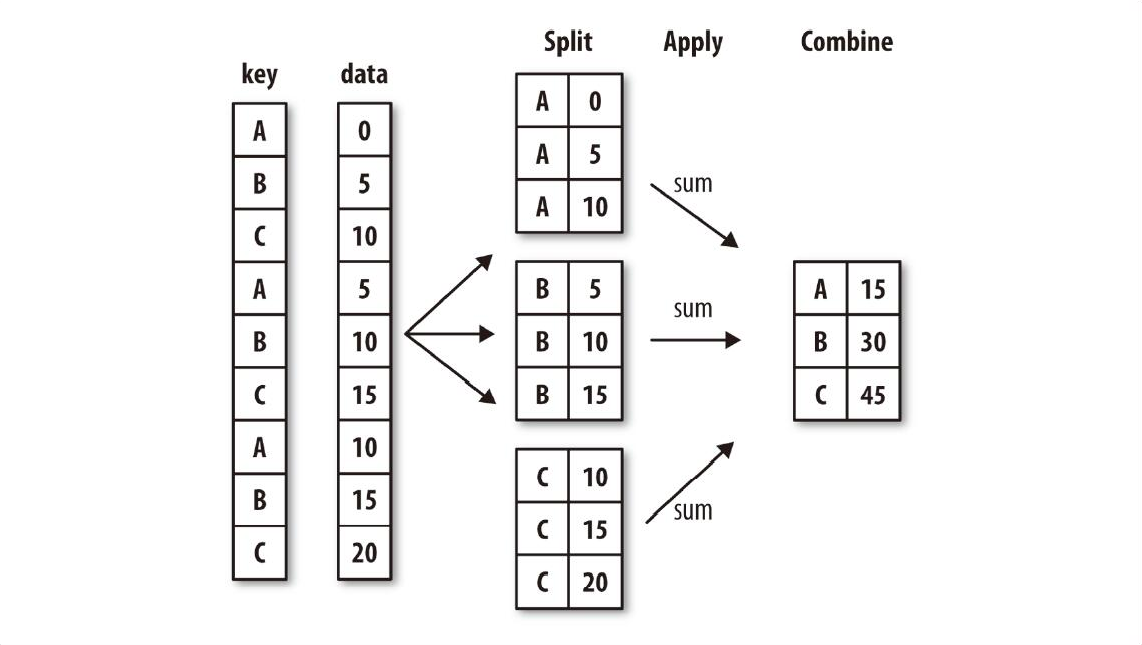

分组键可是多种形式的，并且键不一定是完全相同的类型：

* 与需要分组的轴向长度一致的值列表或值数组

* DataFrame的列名的值

* 可以将分组轴向上的值和分组名称相匹配的字典或Series

* 可以在轴索引或索引中的单个标签上调用的函数

请注意后面介绍的三个方法是可以产生用于分隔对象的值数组的快捷方式。如果感到抽象也不必担心。后面将给出这些方法的许多例子。下面是一个小型表格数据集作为DataFrame的例子：

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

df

,key1,key2,data1,data2
0,a,one,0.031278,-0.310065
1,a,two,-0.750400,1.052097
2,b,one,-0.630397,-1.632919
3,b,two,-1.679409,-0.282766
4,a,one,0.322757,-0.179896


假设想要根据key1标签计算data1列的均值，有多种方法可以实现。其中一种是访问data1并使用key1列（它是一个Series）调用`groupby`方法：

In [3]:
# grouped = df['data1'].groupby(df['key1'])
grouped = df[['data1', 'data2']].groupby(df['key1'])
grouped

grouped变量现在是一个GroupBy对象。除了一些关于分组键df['key1']的一些中间数据之外，它实际上还没有进行任何计算。这个对象拥有所有必需的信息，之后可以在每一个分组上应用一些操作。例如，为了计算分组的均值我们可以调用GroupBy的`mean`方法：

In [4]:
grouped.mean()

,data1,data2
key1,,
a,-0.132122,0.187379
b,-1.154903,-0.957843


之后，会更多地解释调用`mean()`时发生了什么。数据（一个Series）根据分组键进行了聚合，并产生了一个新的Series，这个Series使用key1列的唯一值作为索引。由于DataFrame的列df['key1']，结果中的索引名称是'key1'。

如果将多个数组作为列表传入，则会得到一些不同的结果：

In [5]:
means = df[['data1', 'data2']].groupby([df['key1'], df['key2']]).mean()

means

data1     data2
key1 key2                    
a    one   0.177017 -0.244980
     two  -0.750400  1.052097
b    one  -0.630397 -1.632919
     two  -1.679409 -0.282766

这里使用了两个键对数据进行分组，并且结果Series现在拥有一个包含唯一键对的多层索引：

In [6]:
means.unstack()

data1               data2          
key2       one       two       one       two
key1                                        
a     0.177017 -0.750400 -0.244980  1.052097
b    -0.630397 -1.679409 -1.632919 -0.282766

在这个例子中，分组键都是Series，尽管分组键也可以是正确长度的任何数组：

In [7]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

years = np.array([2005, 2005, 2006, 2005, 2006])

# 这种操作比较奇异，不在原有DataFrame中也可以做聚合， 内部机制就是说只和groupby的index有关系。
df['data1'].groupby([states, years, df.key1]).mean()

                  key1
California  2005  a      -0.750400
            2006  b      -0.630397
Ohio        2005  a       0.031278
                  b      -1.679409
            2006  a       0.322757
Name: data1, dtype: float64

In [8]:
df

,key1,key2,data1,data2
0,a,one,0.031278,-0.310065
1,a,two,-0.750400,1.052097
2,b,one,-0.630397,-1.632919
3,b,two,-1.679409,-0.282766
4,a,one,0.322757,-0.179896


分组信息作为你想要继续处理的数据，通常包含在同一个DataFrame中。在这种情况下，可以传递列名（无论那些列名是字符串、数字或其他Python对象）作为分组键：

In [9]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.132122,0.187379
b,-1.154903,-0.957843


In [10]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.177017 -0.244980
     two  -0.750400  1.052097
b    one  -0.630397 -1.632919
     two  -1.679409 -0.282766

第一行代码中`df.groupby（'key1'）.mean()`的结果里并没有key2列。这是因为df['key2']**并不是数值数据**，即df['key2']是一个冗余列，因此被排除在结果之外。默认情况下，所有的数值列都可以聚合，尽管可能会过滤到子集，将在后面的内容看到。

如果不在意使用groupby的目的，通用的GroupBy方法是`size`，`size`方法返回一个包含组大小信息的Series：

In [11]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

> 分组键中的任何缺失值将被排除在结果之外。

### 10.1.1　遍历各分组
GroupBy对象支持迭代，会生成一个包含组名和数据块的2维元组序列。考虑以下代码：

In [12]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one  0.031278 -0.310065
1    a  two -0.750400  1.052097
4    a  one  0.322757 -0.179896
b
  key1 key2     data1     data2
2    b  one -0.630397 -1.632919
3    b  two -1.679409 -0.282766


在多个分组键的情况下，元组中的第一个元素是键值的元组：

In [13]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.031278 -0.310065
4    a  one  0.322757 -0.179896
('a', 'two')
  key1 key2   data1     data2
1    a  two -0.7504  1.052097
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.630397 -1.632919
('b', 'two')
  key1 key2     data1     data2
3    b  two -1.679409 -0.282766


In [14]:
for i in df.groupby(['key1', 'key2']):
    print(i[0], "|", i[1])

('a', 'one') |   key1 key2     data1     data2
0    a  one  0.031278 -0.310065
4    a  one  0.322757 -0.179896
('a', 'two') |   key1 key2   data1     data2
1    a  two -0.7504  1.052097
('b', 'one') |   key1 key2     data1     data2
2    b  one -0.630397 -1.632919
('b', 'two') |   key1 key2     data1     data2
3    b  two -1.679409 -0.282766


当然，可以选择在任何一块数据上进行你想要的操作。使用一行代码计算出数据块的字典可能会对你有用：

In [15]:
pieces = dict(list(df.groupby('key1')))

pieces['b']

,key1,key2,data1,data2
2,b,one,-0.630397,-1.632919
3,b,two,-1.679409,-0.282766


默认情况下，`groupby`在`axis=0`的轴向上分组，但也可以在其他任意轴向上进行分组。可以像以下代码一样，根据`dtype`对示例df的列进行分组：

In [16]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [17]:
grouped = df.groupby(df.dtypes, axis=1)

可以打印各分组，如下：

In [18]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  0.031278 -0.310065
1 -0.750400  1.052097
2 -0.630397 -1.632919
3 -1.679409 -0.282766
4  0.322757 -0.179896
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 10.1.2　选择一列或所有列的子集
将从DataFrame创建的GroupBy对象用列名称或列名称数组进行索引时，会产生用于聚合的列子集的效果。这表明：
```
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]
```
是下面代码的语法糖：
```
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])
```
尤其是对于大型数据集，可能只需要聚合少部分列。例如，在处理数据集时，要计算data2列的均值，并获得DataFrame形式的结果，我们可以写：

In [19]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.244980
     two   1.052097
b    one  -1.632919
     two  -0.282766

如果传递的是列表或数组，则此索引操作返回的对象是分组的DataFrame；如果只有单个列名作为标量传递，则为分组的Series：

In [20]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

s_grouped

s_grouped.mean()

key1  key2
a     one    -0.244980
      two     1.052097
b     one    -1.632919
      two    -0.282766
Name: data2, dtype: float64

### 10.1.3　使用字典和Series分组
分组信息可能会以非数组形式存在。考虑另一个示例DataFrame：

In [21]:
people = pd.DataFrame(np.arange(25.0).reshape(5,5), # np.random.randn(5, 5), 还是这种容易看规律
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

people.loc[ [ 'Wes'], ['b', 'c']] = np.nan # Add a few NA values
# 或者使用iloc方法
# people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,0.0,1.0,2.0,3.0,4.0
Steve,5.0,6.0,7.0,8.0,9.0
Wes,10.0,NaN,NaN,13.0,14.0
Jim,15.0,16.0,17.0,18.0,19.0
Travis,20.0,21.0,22.0,23.0,24.0


现在，假设拥有各列的分组对应关系，并且想把各列按组累加：

In [22]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

现在，可以根据这个字典构造传给groupby的数组，但是也可以直接传字典（**多写了键'f'用于表明未用的分组键也是没问题的**）：

In [23]:
by_column = people.groupby(mapping, axis=1)

by_column.sum()

,blue,red
Joe,5.0,5.0
Steve,15.0,20.0
Wes,13.0,24.0
Jim,35.0,50.0
Travis,45.0,65.0


Series也有相同的功能，可以视为固定大小的映射：

In [24]:
map_series = pd.Series(mapping)

map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [25]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 10.1.4　使用函数分组
与使用字典或Series分组相比，使用Python函数是定义分组关系的一种更为通用的方式。作为分组键传递的函数将会按照每个索引值调用一次，同时返回值会被用作分组名称。更具体地说，考虑上一节中的示例DataFrame，其中人的名字作为索引值。假设想根据名字的长度来进行分组。虽然可以计算出字符串长度的数组，但传递`len`函数更为简单：

In [26]:
people

,a,b,c,d,e
Joe,0.0,1.0,2.0,3.0,4.0
Steve,5.0,6.0,7.0,8.0,9.0
Wes,10.0,NaN,NaN,13.0,14.0
Jim,15.0,16.0,17.0,18.0,19.0
Travis,20.0,21.0,22.0,23.0,24.0


In [27]:
people.groupby(len).sum()

,a,b,c,d,e
3,25.0,17.0,19.0,34.0,37.0
5,5.0,6.0,7.0,8.0,9.0
6,20.0,21.0,22.0,23.0,24.0


将函数与数组、字典或Series进行混合并不困难，所有的对象都会在内部转换为数组：

In [28]:
key_list = ['one', 'one', 'one', 'two', 'two']

people.groupby([len, key_list]).min()

a     b     c     d     e
3 one   0.0   1.0   2.0   3.0   4.0
  two  15.0  16.0  17.0  18.0  19.0
5 one   5.0   6.0   7.0   8.0   9.0
6 two  20.0  21.0  22.0  23.0  24.0

### 10.1.5　根据索引层级分组
分层索引的数据集有一个非常方便的地方，就是能够在轴索引的某个层级上进行聚合。例子：

In [29]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                    names=['city', 'tenor'])

# hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df = pd.DataFrame(np.arange(20).reshape(4,5), columns=columns)

hier_df

city   US          JP    
tenor   1   3   5   1   3
0       0   1   2   3   4
1       5   6   7   8   9
2      10  11  12  13  14
3      15  16  17  18  19

根据层级分组时，将层级数值或层级名称传递给level关键字：

In [30]:
hier_df.groupby(level='city', axis=1).sum()

city,JP,US
0,7,3
1,17,18
2,27,33
3,37,48


## 10.2　数据聚合
聚合是指所有根据数组产生标量值的数据转换过程。之前的例子已经使用了一些聚合操作，包括`mean`、`count`、`min`和`sum`等。很多常见的聚合，例如下表中的操作都有了优化实现。然而，要用的可能并不局限于下面这个方法集。

|    函数名    |           描述           |
| ----------- | ------------------------ |
| count       | 分组中的非NA值数量         |
| sum         | 非NA值的累和              |
| mean        | 非NA值的均值              |
| median      | 非NA值的算术中位数         |
| std, var    | 无偏的(n-1分母)标准差和方差 |
| min, max    | 非NA值的最小值、最大值      |
| prod        | 非NA值的乘积              |
| first, last | 非NA值的第一个和最后一个值  |

可以使用自行制定的聚合，并再调用已经在分组对象上定义好的方法。例如，`quantile`可以计算Series或DataFrame列的样本分位数。

尽管`quantile`并不是显式地为GroupBy对象实现的，但它是Series的方法，因此也可以用于聚合。在内部，GroupBy有效地对Series进行切片，为每一块调用`piece.quantile(0.9)`，然后将这些结果一起组装到结果对象中：

In [31]:
df

,key1,key2,data1,data2
0,a,one,0.031278,-0.310065
1,a,two,-0.750400,1.052097
2,b,one,-0.630397,-1.632919
3,b,two,-1.679409,-0.282766
4,a,one,0.322757,-0.179896


In [32]:
grouped = df.groupby('key1')

grouped['data1'].quantile(0.9)

key1
a    0.264461
b   -0.735298
Name: data1, dtype: float64

要使用自己的聚合函数，需要将函数传递给aggregate或agg方法：

In [33]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.073156,1.362162
b,1.049013,1.350153


某些方法，比如`describe`也是有效的，尽管严格来说它们并不是聚合函数：

In [34]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.132122  0.554924 -0.750400 -0.359561  0.031278  0.177017   
b      2.0 -1.154903  0.741764 -1.679409 -1.417156 -1.154903 -0.892650   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     0.322757   3.0  0.187379  0.751691 -0.310065 -0.244980 -0.179896   
b    -0.630397   2.0 -0.957843  0.954702 -1.632919 -1.295381 -0.957843   

                          
           75%       max  
key1                      
a     0.436101  1.052097  
b    -0.620304 -0.282766

> 自定义聚合函数通常比上表中的优化函数慢得多。这是因为在构造中间组数据块时有一些额外的开销（函数调用、数据重新排列）

### 10.2.1　逐列及多函数应用
回到之前例子中的tips数据集。在使用`read_csv`载入数据集后，增加一个小费比例列tip-pct：

In [35]:
tips = pd.read_csv('examples/tips.csv')

# 添加总账单的小费比例
tips['tip_pct'] = tips['tip'] / tips['total_bill']

tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


对Series或DataFrame所有列进行聚合就是使用`aggregate`和所需函数，或者是调用像`mean`或`std`这种方法的。然而，如果想根据各列同时使用多个函数进行聚合。这是可以做到的，将根据day和smoker来对tips进行分组：

In [36]:
grouped = tips.groupby(['day', 'smoker'])

grouped_pct = grouped['tip_pct']

# grouped.mean()
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

如果传递的是函数或者函数名的列表，会获得一个列名是这些函数名的DataFrame：

In [37]:
grouped_pct.agg(['mean', 'std', peak_to_peak])     

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

这里传递了聚合函数的列表给`agg`方法，这些函数会各自运用于数据分组。

可以不接受GroupBy对象给予各列的名称。请注意，`lambda`函数具有名称`'<lambda>'`，这使得它们难以识别（可以查看函数的`__name__`属性）。因此，如果传递的是`(name，function)`元组的列表，每个元组的第一个元素将作为DataFrame的列名（可以认为二元元组的列表是一种有序的对应关系）：

In [38]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

在DataFrame中，有更多的选项，可以指定应用到所有列上的函数列表或每一列上要应用的不同函数。假设想要计算tip_pct列和total_bill列的三个相同的统计值：

In [39]:
functions = ['count', 'mean', 'max']
grouped.aggregate(functions)

total_bill                     tip                   size  \
                 count       mean    max count      mean    max count   
day  smoker                                                             
Fri  No              4  18.420000  22.75     4  2.812500   3.50     4   
     Yes            15  16.813333  40.17    15  2.714000   4.73    15   
Sat  No             45  19.661778  48.33    45  3.102889   9.00    45   
     Yes            42  21.276667  50.81    42  2.875476  10.00    42   
Sun  No             57  20.506667  48.17    57  3.167895   6.00    57   
     Yes            19  24.120000  45.35    19  3.516842   6.50    19   
Thur No             45  17.113111  41.19    45  2.673778   6.70    45   
     Yes            17  19.190588  43.11    17  3.030000   5.00    17   

                          tip_pct                      
                 mean max   count      mean       max  
day  smoker                                            
Fri  No      2.250000   3       4  0.151650  0.187735  
     Yes     2.066667   4      15  0.174783  0.263480  
Sat  No      2.555556   4      45  0.158048  0.291990  
     Yes     2.476190   5      42  0.147906  0.325733  
Sun  No      2.929825   6      57  0.160113  0.252672  
     Yes     2.578947   5      19  0.187250  0.710345  
Thur No      2.488889   6      45  0.160298  0.266312  
     Yes     2.352941   4      17  0.163863  0.241255

In [40]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

产生的DataFrame拥有分层列，与分别聚合每一列，再以列名作为keys参数使用`concat`将结果拼接在一起的结果相同：

In [41]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

和以前一样，可以传递具有自定义名称的元组列表：

In [42]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

# grouped['tip_pct', 'total_bill'].agg(ftuples)

grouped['tip_pct', 'total_bill'].agg(['mean', np.var])

tip_pct           total_bill            
                 mean       var       mean         var
day  smoker                                           
Fri  No      0.151650  0.000791  18.420000   25.596333
     Yes     0.174783  0.002631  16.813333   82.562438
Sat  No      0.158048  0.001581  19.661778   79.908965
     Yes     0.147906  0.003767  21.276667  101.387535
Sun  No      0.160113  0.001793  20.506667   66.099980
     Yes     0.187250  0.023757  24.120000  109.046044
Thur No      0.160298  0.001503  17.113111   59.625081
     Yes     0.163863  0.001551  19.190588   69.808518

现在假设想要将不同的函数应用到一个或多个列上。要实现这个功能，需要将含有列名与函数对应关系的**字典**传递给`agg`：

In [43]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [44]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

> 只有多个函数应用于至少一个列时，DataFrame才具有分层列。

### 10.2.2　返回不含行索引的聚合数据
在前面所有的例子中，聚合数据返回时都是带有索引的，有时索引是分层的，由唯一的分组键联合形成。因为不是所有的情况下都需要索引，所以在大多数情况下可以通过向`groupby`传递`as_index=False`来禁用分组键作为索引的行为：

In [45]:
# 不将group的项作为索引
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


通过在结果上调用`reset_index`也可以获得同样的结果。使用`as_index=False`可以避免一些不必要的计算。

## 10.3　应用：通用拆分-应用-联合
GroupBy方法最常见的目的是apply（应用），apply将对象拆分成多块，然后在每一块上调用传递的函数，之后尝试将每一块拼接到一起。


回到之前的tips数据集，假设想要按组选出小费百分比（tip-pct）最高的五组。首先，写一个可以在特定列中选出最大值所在行的函数：

In [46]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


现在，如果按照smoker进行分组，之后调用`apply`，会得到以下结果：

In [47]:
# somker分别是yes和no的tip_pct最大的5项
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

`top`函数在DataFrame的每一行分组上被调用，之后使用`pandas.concat`将函数结果粘贴在一起，并使用分组名作为各组的标签。因此结果包含一个分层索引，该分层索引的内部层级包含原DataFrame的索引值：

如果除了向`apply`传递函数，还传递其他参数或关键字的话，可以把这些放在函数后进行传递：

In [48]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')       

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

In [49]:
tips.groupby(['smoker']).apply(top, n=1, column='tip_pct')

,,total_bill,tip,smoker,day,time,size,tip_pct
smoker,,,,,,,,
No,232,11.61,3.39,No,Sat,Dinner,2,0.291990
Yes,172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


> 除了基础的使用机制，还需要一些创造力才能充分地使用`apply`。传递函数的内部发生的事情取决于自己，函数只需要返回一个pandas对象或一个标量值。

之前在GroupBy对象上调用了`describe`方法：

In [50]:
result = tips.groupby('smoker')['tip_pct'].describe()

result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [51]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

在GroupBy对象的内部，当调用像`describe`这样的方法时，实际上是以下代码的简写：

In [52]:
f = lambda x: x.describe()
grouped.apply(f).unstack()

total_bill                                                        \
                 count       mean        std    min     25%     50%      75%   
day  smoker                                                                    
Fri  No            4.0  18.420000   5.059282  12.46  15.100  19.235  22.5550   
     Yes          15.0  16.813333   9.086388   5.75  11.690  13.420  18.6650   
Sat  No           45.0  19.661778   8.939181   7.25  14.730  17.820  20.6500   
     Yes          42.0  21.276667  10.069138   3.07  13.405  20.390  26.7925   
Sun  No           57.0  20.506667   8.130189   8.77  14.780  18.430  25.0000   
     Yes          19.0  24.120000  10.442511   7.25  17.165  23.100  32.3750   
Thur No           45.0  17.113111   7.721728   7.51  11.690  15.950  20.2700   
     Yes          17.0  19.190588   8.355149  10.34  13.510  16.470  19.8100   

                     tip            ...  size      tip_pct            \
               max count      mean  ...   75%  max   count      mean   
day  smoker                         ...                                
Fri  No      22.75   4.0  2.812500  ...  2.25  3.0     4.0  0.151650   
     Yes     40.17  15.0  2.714000  ...  2.00  4.0    15.0  0.174783   
Sat  No      48.33  45.0  3.102889  ...  3.00  4.0    45.0  0.158048   
     Yes     50.81  42.0  2.875476  ...  3.00  5.0    42.0  0.147906   
Sun  No      48.17  57.0  3.167895  ...  4.00  6.0    57.0  0.160113   
     Yes     45.35  19.0  3.516842  ...  3.00  5.0    19.0  0.187250   
Thur No      41.19  45.0  2.673778  ...  2.00  6.0    45.0  0.160298   
     Yes     43.11  17.0  3.030000  ...  2.00  4.0    17.0  0.163863   

                                                                         
                  std       min       25%       50%       75%       max  
day  smoker                                                              
Fri  No      0.028123  0.120385  0.137239  0.149241  0.163652  0.187735  
     Yes     0.051293  0.103555  0.133739  0.173913  0.209240  0.263480  
Sat  No      0.039767  0.056797  0.136240  0.150152  0.183915  0.291990  
     Yes     0.061375  0.035638  0.091797  0.153624  0.190502  0.325733  
Sun  No      0.042347  0.059447  0.139780  0.161665  0.185185  0.252672  
     Yes     0.154134  0.065660  0.097723  0.138122  0.215325  0.710345  
Thur No      0.038774  0.072961  0.137741  0.153492  0.184843  0.266312  
     Yes     0.039389  0.090014  0.148038  0.153846  0.194837  0.241255  

[8 rows x 32 columns]

In [53]:
grouped.describe()

total_bill                                                        \
                 count       mean        std    min     25%     50%      75%   
day  smoker                                                                    
Fri  No            4.0  18.420000   5.059282  12.46  15.100  19.235  22.5550   
     Yes          15.0  16.813333   9.086388   5.75  11.690  13.420  18.6650   
Sat  No           45.0  19.661778   8.939181   7.25  14.730  17.820  20.6500   
     Yes          42.0  21.276667  10.069138   3.07  13.405  20.390  26.7925   
Sun  No           57.0  20.506667   8.130189   8.77  14.780  18.430  25.0000   
     Yes          19.0  24.120000  10.442511   7.25  17.165  23.100  32.3750   
Thur No           45.0  17.113111   7.721728   7.51  11.690  15.950  20.2700   
     Yes          17.0  19.190588   8.355149  10.34  13.510  16.470  19.8100   

                     tip            ...  size      tip_pct            \
               max count      mean  ...   75%  max   count      mean   
day  smoker                         ...                                
Fri  No      22.75   4.0  2.812500  ...  2.25  3.0     4.0  0.151650   
     Yes     40.17  15.0  2.714000  ...  2.00  4.0    15.0  0.174783   
Sat  No      48.33  45.0  3.102889  ...  3.00  4.0    45.0  0.158048   
     Yes     50.81  42.0  2.875476  ...  3.00  5.0    42.0  0.147906   
Sun  No      48.17  57.0  3.167895  ...  4.00  6.0    57.0  0.160113   
     Yes     45.35  19.0  3.516842  ...  3.00  5.0    19.0  0.187250   
Thur No      41.19  45.0  2.673778  ...  2.00  6.0    45.0  0.160298   
     Yes     43.11  17.0  3.030000  ...  2.00  4.0    17.0  0.163863   

                                                                         
                  std       min       25%       50%       75%       max  
day  smoker                                                              
Fri  No      0.028123  0.120385  0.137239  0.149241  0.163652  0.187735  
     Yes     0.051293  0.103555  0.133739  0.173913  0.209240  0.263480  
Sat  No      0.039767  0.056797  0.136240  0.150152  0.183915  0.291990  
     Yes     0.061375  0.035638  0.091797  0.153624  0.190502  0.325733  
Sun  No      0.042347  0.059447  0.139780  0.161665  0.185185  0.252672  
     Yes     0.154134  0.065660  0.097723  0.138122  0.215325  0.710345  
Thur No      0.038774  0.072961  0.137741  0.153492  0.184843  0.266312  
     Yes     0.039389  0.090014  0.148038  0.153846  0.194837  0.241255  

[8 rows x 32 columns]

### 10.3.1　压缩分组键
在之前的例子中，可以看到所得到的对象具有分组键所形成的分层索引以及每个原始对象的索引。可以通过向`groupby`传递`group_keys=False`来禁用这个功能：

In [54]:
print(tips.groupby('smoker', group_keys=False).apply(top).index)
tips.groupby('smoker', group_keys=False).apply(top)

Int64Index([88, 185, 51, 149, 232, 109, 183, 67, 178, 172], dtype='int64')


,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [55]:
print(tips.groupby('smoker').apply(top).index)
tips.groupby('smoker').apply(top)

MultiIndex(levels=[['No', 'Yes'], [51, 67, 88, 109, 149, 172, 178, 183, 185, 232]],
           codes=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [2, 8, 0, 4, 9, 3, 7, 1, 6, 5]],
           names=['smoker', None])


total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

### 10.3.2　分位数与桶分析
pandas有一些工具，尤其是`cut`和`qcut`，用于将数据按照选择的箱位或样本分位数进行分桶。与`groupby`方法一起使用这些函数可以对数据集更方便地进行分桶或分位分析。考虑一个简单的随机数据集和一个使用`cut`的等长桶分类：

In [56]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})

quartiles = pd.cut(frame.data1, 4)

quartiles.head()

0    (-2.866, -1.343]
1       (0.174, 1.69]
2     (-1.343, 0.174]
3     (-1.343, 0.174]
4       (0.174, 1.69]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.866, -1.343] < (-1.343, 0.174] < (0.174, 1.69] < (1.69, 3.207]]

`cut`返回的`Categorical`对象可以直接传递给`groupby`。所以可以计算出data2列的一个统计值集合，如下：

In [57]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(quartiles)

In [58]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.866, -1.343]",81.0,2.521602,-0.063143,-1.895468
"(-1.343, 0.174]",501.0,3.192920,-0.041439,-3.468998
"(0.174, 1.69]",376.0,2.941399,-0.025430,-2.771815
"(1.69, 3.207]",42.0,1.976954,0.124663,-2.624339


这些就是等长桶。为了根据样本分位数计算出等大小的桶，则需要使用`qcut`。传递`labels=False`来获得分位数数值：

In [59]:
# 返回分位数数值
grouping = pd.qcut(frame.data1, 10, labels=False)

grouped = frame.data2.groupby(grouping)

grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.521602,-0.077293,-1.895468
1,100.0,2.437359,0.019058,-2.735986
2,100.0,2.792246,-0.017373,-3.468998
3,100.0,3.192920,-0.018102,-2.826562
4,100.0,2.242027,-0.013826,-2.714425
5,100.0,2.884615,-0.071669,-2.766358
6,100.0,2.331257,-0.177292,-2.495182
7,100.0,2.941399,0.026887,-2.771815
8,100.0,2.277868,-0.089842,-2.508142


### 10.3.3　示例：使用指定分组值填充缺失值
在清除缺失值时，有时会使用`dropna`来去除缺失值，但是有时可能想要使用修正值或来自于其他数据的值来输入（填充）到null值（NA）。`fillna`是一个可以使用的正确工具，例如这里使用平均值来填充NA值：

In [60]:
# s = pd.Series(np.random.randn(6))
s = pd.Series(np.arange(6))


s[::2] = np.nan

s

0    NaN
1    1.0
2    NaN
3    3.0
4    NaN
5    5.0
dtype: float64

In [61]:
s.fillna(s.mean())

0    3.0
1    1.0
2    3.0
3    3.0
4    3.0
5    5.0
dtype: float64

假设需要填充值按组来变化。一个方法是对数据分组后使用`apply`和一个在每个数据块上都调用`fillna`的函数。下面是一些将美国分为东部地区和西部地区的样本数据：

In [62]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']

group_key = ['East'] * 4 + ['West'] * 4

# data = pd.Series(np.random.randn(8), index=states)
data = pd.Series(np.arange(8), index=states)

data

Ohio          0
New York      1
Vermont       2
Florida       3
Oregon        4
Nevada        5
California    6
Idaho         7
dtype: int64

> 语法`['East']*4`生成了一个包含四个['East']中元素的备份的列表。将列表拼接在一起。

将数据中的一些值设置为缺失值：

In [63]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

data

Ohio          0.0
New York      1.0
Vermont       NaN
Florida       3.0
Oregon        4.0
Nevada        NaN
California    6.0
Idaho         NaN
dtype: float64

In [64]:
data.groupby(group_key).mean()

East    1.333333
West    5.000000
dtype: float64

使用分组的平均值来填充NA值，如下：

In [65]:
fill_mean = lambda g: g.fillna(g.mean())

data.groupby(group_key).apply(fill_mean)

Ohio          0.000000
New York      1.000000
Vermont       1.333333
Florida       3.000000
Oregon        4.000000
Nevada        5.000000
California    6.000000
Idaho         5.000000
dtype: float64

在另一种情况下，可能已经在代码中为每个分组预定义了填充值。由于每个分组都有一个内置的`name`属性，可以这样使用：

In [66]:
fill_values = {'East': -1, 'West': -2}

fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby(group_key).apply(fill_func)

Ohio          0.0
New York      1.0
Vermont      -1.0
Florida       3.0
Oregon        4.0
Nevada       -2.0
California    6.0
Idaho        -2.0
dtype: float64

### 10.3.4　示例：随机采样与排列
假设想从大数据集中抽取随机样本（有或没有替换）以用于蒙特卡罗模拟目的或某些其他应用程序。有很多方法来执行“抽取”，这里使用Series的sample方法。

为了演示，讲解一种构造一副英式扑克牌的方法：

In [67]:
# 红桃，黑桃，梅花，方块
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)
    
deck = pd.Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

因此现在拥有了一个长度为52的Series，Series的索引包含了牌名，Series的值可以用于Blackjack和其他游戏（为了保持简单，让'A'为1）：

现在，从这副牌中拿出五张牌可以写成：

In [68]:
def draw(deck, n=5):
    return deck.sample(n)

draw(deck, n=7)

9H     9
5D     5
QD    10
JH    10
KH    10
9C     9
2S     2
dtype: int64

假设想要从每个花色中随机抽取两张牌。由于花色是牌名的最后两个字符，可以基于这点进行分组，并使用apply：

In [69]:
get_suit = lambda card: card[-1] # last letter is suit

deck.groupby(get_suit).apply(draw, n=2)

C  5C     5
   2C     2
D  2D     2
   7D     7
H  2H     2
   6H     6
S  KS    10
   QS    10
dtype: int64

或者也可以写成：

In [70]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

10C    10
4C      4
8D      8
7D      7
6H      6
9H      9
AS      1
3S      3
dtype: int64

### 10.3.5　示例：分组加权平均和相关性
在`groupby`的拆分-应用-联合的范式下，DataFrame的列间操作或两个Seriese之间的操作，例如分组加权平均是可以做到的。作为一个例子，使用一个包含分组键和权重值的数据集：

In [71]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.arange(1,9),
                   'weights': np.arange(10, 18)})
                   # 'data': np.random.randn(8),
                   # 'weights': np.random.rand(8)})

df

,category,data,weights
0,a,1,10
1,a,2,11
2,a,3,12
3,a,4,13
4,b,5,14
5,b,6,15
6,b,7,16
7,b,8,17


通过`category`进行分组加权平均如下：

In [72]:
grouped = df.groupby('category')

# weights作为权重
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

grouped.apply(get_wavg)

category
a    2.608696
b    6.580645
dtype: float64

作为另一个例子，考虑一个从雅虎财经上获得的数据集，该数据集包含一些标普500（SPX符号）和股票的收盘价：

In [73]:
close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True,
                       index_col=0)

close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [74]:
close_px.describe()

,AAPL,MSFT,XOM,SPX
count,2214.000000,2214.000000,2214.000000,2214.000000
mean,125.516147,23.945452,59.558744,1183.773311
std,107.394693,3.255198,16.725025,180.983466
min,6.560000,14.330000,26.210000,676.530000
25%,37.135000,21.700000,49.492500,1077.060000
50%,91.455000,24.000000,62.970000,1189.260000
75%,185.605000,26.280000,72.510000,1306.057500
max,422.000000,34.070000,87.480000,1565.150000


In [75]:
close_px.tail(n=4)

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


一个有趣的任务可能是计算一个DataFrame，它包含标普指数（SPX）每日收益的年度相关性（通过百分比变化计算）。作为实现的一种方式，首先创建一个计算每列与'SPX'列成对关联的函数：

In [76]:
spx_corr = lambda x: x.corrwith(x['SPX'])

之后，使用`pct_change`计算close-px百分比的变化：

In [77]:
# rets = close_px.pct_change().dropna()
rets = close_px.pct_change().dropna()

最后，按年对百分比变化进行分组，可以使用单行函数从每个行标签中提取每个datetime标签的year属性：

In [78]:
get_year = lambda x: x.year

by_year = rets.groupby(get_year)

by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


也可以计算内部列相关性。这里计算了苹果和微软的年度相关性：

In [79]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 10.3.6　示例：逐组线性回归
在与前一个示例相同的主题中，只要该函数返回一个pandas对象或标量值，就可以使用`groupby`执行更复杂的按分组统计分析。例如，定义以下regress（回归）函数（使用`statsmodels`计量经济学库），该函数对每个数据块执行普通最小二乘（OLS）回归：

In [80]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

现在，要计算AAPL在SPX回报上的年度线性回归，执行以下代码：

In [81]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 10.4　数据透视表与交叉表
数据透视表是电子表格程序和其他数据分析软件中常见的数据汇总工具。它根据一个或多个键聚合一张表的数据，将数据在矩形格式中排列，其中一些分组键是沿着行的，另一些是沿着列的。Python中的pandas透视表是通过本章所介绍的groupby工具以及使用分层索引的重塑操作实现的。DataFrame拥有一个`pivot_table`方法，并且还有还一个顶层的`pandas.pivot_table`函数。除了为`groupby`提供一个方便接口，`pivot_table`还可以添加部分总计，也称作边距。

回到tips数据集，假设想要计算一张在行方向上按day和smoker排列的**`分组平均值`**（默认的pivot_table聚合类型）的表：

In [82]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [83]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

这个功能也可以直接使用`groupby`实现。现在，假设只想在tip_pct和size上进行聚合，并根据time分组。把smoker放入表的列，而将day放入表的行：

In [84]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

可以通过传递`margins=True`来扩充这个表来包含部分总计(类似于SQL中的rollup)。这会添加All行和列标签，其中相应的值是单层中所有数据的分组统计值：

In [85]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

这里，All的值是均值，且该均值是不考虑吸烟者与非吸烟者（All列）或行分组中任何两级的（All行）。

要使用不同的聚合函数时，将函数传递给`aggfunc`。例如，'count'或者len将给出一张分组大小的交叉表（计数或出现频率）：

In [86]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

如果某些情况下产生了空值（或者NA），可能想要传递一个fill_value：

In [87]:
tips.pivot_table('tip_pct', index=['time',  'smoker'],
                 columns='day', aggfunc=['mean',np.count_nonzero], fill_value=0, margins=True)

mean                                         count_nonzero  \
day                 Fri       Sat       Sun      Thur       All           Fri   
time   smoker                                                                   
Dinner No      0.139622  0.158048  0.160113  0.159744  0.158653             3   
       Yes     0.165347  0.147906  0.187250  0.000000  0.160828             9   
Lunch  No      0.187735  0.000000  0.000000  0.160311  0.160920             1   
       Yes     0.188937  0.000000  0.000000  0.163863  0.170404             6   
All            0.169913  0.153152  0.166897  0.161276  0.160803            19   

                                   
day           Sat Sun Thur    All  
time   smoker                      
Dinner No      45  57    1  106.0  
       Yes     42  19    0   70.0  
Lunch  No       0   0   44   45.0  
       Yes      0   0   17   23.0  
All            87  76   62  244.0

下表是`pivot_table`方法的概括。

|    选项    |                               描述                                |
| ---------- | ----------------------------------------------------------------- |
| values     | 需要聚合的列名;默认情况下聚合所有数值型的列                            |
| index      | 在结果透视表的行上进行分组的列名或其他分组键                           |
| columns    | 在结果透视表的列上进行分组的列名或其他分组键                           |
| aggfunc    | 聚合函数或函数列表(默认情况下是'mean');<br>可以是 groupby上下文的任意有效函数 |
| fill_value | 在结果表中替换缺失值的值                                             |
| dropna     | 如果为True,将不含所有条目均为NA的列                                  |
| margins    | 添加行/列小计和总计(默认为Fa1se)                                     |

### 10.4.1　交叉表：crosstab
交叉表（简写为crosstab）是数据透视表的一个特殊情况，计算的是分组中的频率。下面是个例子：

In [88]:
data = pd.read_excel('examples/nation_hand.xlsx', index_col='index')

作为研究分析的一部分，可能想按照国籍和惯用性来总结这些数据。可以使用`pivot_table`来实现这个功能，但是`pandas.crosstable`函数更为方便：

In [89]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


crosstab的前两个参数可是数组、Series或数组的列表。在小费数据中可以这么做：

In [90]:
pd.crosstab([tips['time'], tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

In [91]:
# 使用pivot_table进行改写
tips.pivot_table('size',index=['time','day'], columns='smoker', aggfunc=len, margins=True)

smoker          No   Yes  All
time   day                   
Dinner Fri     3.0   9.0   12
       Sat    45.0  42.0   87
       Sun    57.0  19.0   76
       Thur    1.0   NaN    1
Lunch  Fri     1.0   6.0    7
       Thur   44.0  17.0   61
All          151.0  93.0  244